## Tema Geral do Trabalho

**A Inclusão Digital nas Escolas Públicas Brasileiras**


O trabalho se valerá de ferramentas de ciências de dados para explorar os acessos digitais nas escolas públicas e suas implicações na vida escolar dos alunos.

Entre essas ferramentas podemos destacar o pacote SHAP, modelos de predição e gráficos GEOPandas.

**Fonte de dados:**

* Programa Banda Larga nas Escolas - http://dados.gov.br/dataset/pble
* Micro Dados da Educação - http://portal.inep.gov.br/microdados

## Integrantes

### Gleisson Bispo
### Lorena Corina
### Marcos Azevedo
### Maxwell G Marcos
### Rodrigo Pasqualucci


Última Edição - Gleisson Bispo - 18/07/2019

---

In [ ]:
!pip install shap

     |████████████████████████████████| 235kB 4.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/00/20/87/d199e4d7397997f5494e4098104f91313ac8120753bee7b032
Successfully built shap


# Preparando Análise

## Bibliotecas

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from matplotlib import rcParams

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import shap

shap.initjs()
import warnings
warnings.filterwarnings('ignore')

## Lendo Dataset com as Escolas Públicas do Brasil

In [ ]:
df_escolas = pd.read_excel('/content/df_escolas_pub_brasil.xlsx')

In [ ]:
df_escolas.head()

,CO_ENTIDADE,NO_ENTIDADE,CD_GEOCUF,UF,CD_GEOCMU,MUNICIPIO,LATITUDE,LONGITUDE,CAPITAL,ESCOLA_MUNICIPAL,ESCOLA_ESTADUAL,ESCOLA_RURAL,ESCOLA_URBANA,IN_LOCAL_FUNC_PREDIO_ESCOLAR,IN_ALIMENTACAO,IN_AGUA_FILTRADA,IN_AGUA_REDE_PUBLICA,IN_ENERGIA_REDE_PUBLICA,IN_ESGOTO_REDE_PUBLICA,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_QUADRA_ESPORTES,IN_BIBLIOTECA,IN_SALA_LEITURA,IN_EQUIP_RETROPROJETOR,QT_COMP_ALUNO,TP_ATIVIDADE_COMPLEMENTAR,IN_BANDA_LARGA,PBLE,PRESTADORA,VELOCIDADE,TIPO_VELOCIDADE,TECNOLOGIA,DIA_ATIVACAO,MES_ATIVACAO,ANO_ATIVACAO,NOTA_2009,NOTA_2010,NOTA_2011,NOTA_2012,NOTA_2013,NOTA_2014,NOTA_2015,NOTA_2016,NOTA_2017,NOTA_2018,NOTA_FINAL
0,11022370,EMEIEF CARLOS CHAGAS,11,RO,1100320,São Miguel do Guaporé,-11.6953,-62.7192,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11022388,EMEIEF CARLOS GOMES,11,RO,1100320,São Miguel do Guaporé,-11.6953,-62.7192,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,5,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11022450,EEEF DEONILDO CARAGNATTO,11,RO,1100320,São Miguel do Guaporé,-11.6953,-62.7192,0,0,1,0,1,1,1,1,1,1,0,1,0,1,0,1,1,5,0,1,1,OI,10.0,Mbps,ADSL,30.0,12.0,2009.0,NaN,NaN,NaN,341.74,NaN,NaN,462.98,NaN,NaN,NaN,402.36
3,11022469,EMEIEF DEONILDO CARAGNATTO,11,RO,1100320,São Miguel do Guaporé,-11.6953,-62.7192,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11022558,EIEEF HAP BITT TUPARI,11,RO,1100015,Alta Floresta D'Oeste,-11.9283,-61.9953,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dataset Information

In [ ]:
#Info
df_escolas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141672 entries, 0 to 141671
Data columns (total 47 columns):
CO_ENTIDADE                     141672 non-null int64
NO_ENTIDADE                     141672 non-null object
CD_GEOCUF                       141672 non-null int64
UF                              141672 non-null object
CD_GEOCMU                       141672 non-null int64
MUNICIPIO                       141672 non-null object
LATITUDE                        141672 non-null float64
LONGITUDE                       141672 non-null float64
CAPITAL                         141672 non-null int64
ESCOLA_MUNICIPAL                141672 non-null int64
ESCOLA_ESTADUAL                 141672 non-null int64
ESCOLA_RURAL                    141672 non-null int64
ESCOLA_URBANA                   141672 non-null int64
IN_LOCAL_FUNC_PREDIO_ESCOLAR    141672 non-null int64
IN_ALIMENTACAO                  141672 non-null int64
IN_AGUA_FILTRADA                141672 non-null int64
IN_AGUA_REDE_PUBLI

In [ ]:
#Types
df_escolas.dtypes

CO_ENTIDADE                       int64
NO_ENTIDADE                      object
CD_GEOCUF                         int64
UF                               object
CD_GEOCMU                         int64
MUNICIPIO                        object
LATITUDE                        float64
LONGITUDE                       float64
CAPITAL                           int64
ESCOLA_MUNICIPAL                  int64
ESCOLA_ESTADUAL                   int64
ESCOLA_RURAL                      int64
ESCOLA_URBANA                     int64
IN_LOCAL_FUNC_PREDIO_ESCOLAR      int64
IN_ALIMENTACAO                    int64
IN_AGUA_FILTRADA                  int64
IN_AGUA_REDE_PUBLICA              int64
IN_ENERGIA_REDE_PUBLICA           int64
IN_ESGOTO_REDE_PUBLICA            int64
IN_LABORATORIO_INFORMATICA        int64
IN_LABORATORIO_CIENCIAS           int64
IN_QUADRA_ESPORTES                int64
IN_BIBLIOTECA                     int64
IN_SALA_LEITURA                   int64
IN_EQUIP_RETROPROJETOR            int64


In [ ]:
#Valores Nulos
df_escolas.isnull().sum()

CO_ENTIDADE                          0
NO_ENTIDADE                          0
CD_GEOCUF                            0
UF                                   0
CD_GEOCMU                            0
MUNICIPIO                            0
LATITUDE                             0
LONGITUDE                            0
CAPITAL                              0
ESCOLA_MUNICIPAL                     0
ESCOLA_ESTADUAL                      0
ESCOLA_RURAL                         0
ESCOLA_URBANA                        0
IN_LOCAL_FUNC_PREDIO_ESCOLAR         0
IN_ALIMENTACAO                       0
IN_AGUA_FILTRADA                     0
IN_AGUA_REDE_PUBLICA                 0
IN_ENERGIA_REDE_PUBLICA              0
IN_ESGOTO_REDE_PUBLICA               0
IN_LABORATORIO_INFORMATICA           0
IN_LABORATORIO_CIENCIAS              0
IN_QUADRA_ESPORTES                   0
IN_BIBLIOTECA                        0
IN_SALA_LEITURA                      0
IN_EQUIP_RETROPROJETOR               0
QT_COMP_ALUNO            

# Exploração dos Dados

## Excluindo Escolas duplicadas

In [ ]:
#Verificando se existem escolas duplicados
pd.Series(df_escolas['CO_ENTIDADE'].duplicated()).value_counts()

False    141672
Name: CO_ENTIDADE, dtype: int64

## Quantidade de Escolas Públicas (Estaduais e Municipais)

In [ ]:
df_escolas['CO_ENTIDADE'].count()

141672

## Escolas Estaduais e Municipais no Brasil

In [ ]:
estaduais = df_escolas['ESCOLA_ESTADUAL'].sum()
municipais = df_escolas['ESCOLA_MUNICIPAL'].sum()

In [ ]:
df_est_mun = pd.DataFrame({'Tipo_Escola': {0:'Estadual', 1:'Municipal'},
                           'Quantidade':{0:estaduais, 1:municipais}})

df_est_mun

,Tipo_Escola,Quantidade
0,Estadual,30701
1,Municipal,110971


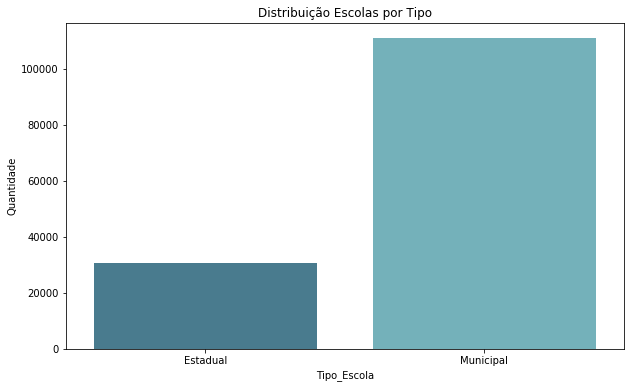

In [ ]:
#Gráfico de tipo de escolas no Brasil
plt.figure(figsize=(10,6))
sns.barplot(data=df_est_mun, x='Tipo_Escola', y='Quantidade', palette='GnBu_d')
plt.title('Distribuição Escolas por Tipo')
plt.show()

## Quantidade de Escolas Públicas por Estado

In [ ]:
df_escolas_uf = pd.DataFrame(df_escolas['UF'].value_counts()).reset_index()
df_escolas_uf.columns = ['UF', 'Quantidade_Escolas']
df_escolas_uf

,UF,Quantidade_Escolas
0,SP,18754
1,BA,14511
2,MG,12215
3,MA,10875
4,PA,9885
5,RS,7331
6,PR,7327
7,RJ,6548
8,PE,6339
9,CE,6120


## Mapa das Escolas por Municipio

### Função para criar um mapa base com o Brasil como referencia

In [ ]:
def generateBaseMap(default_location=[-15.77972, -47.92972], default_zoom_start=4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

### Criando mapa de calor onde existe concentração de escolas

In [ ]:
base_map = generateBaseMap()
df_map = df_escolas[['LATITUDE', 'LONGITUDE']]
df_map['COUNT'] = 1
HeatMap(data=df_map.groupby(['LATITUDE', 'LONGITUDE']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

# Exploração Escolas no Programa PBLE

## Escolas Atendidas no Programa

In [ ]:
print(f"Escolas atendidas no programa PBLE: {df_escolas['PBLE'][df_escolas['PBLE']==1].count()}")

Escolas atendidas no programa PBLE: 58023


## Percentual de Escolas Publicas no Programa

In [ ]:
estaduais = df_escolas['ESCOLA_ESTADUAL'].sum()
municipais = df_escolas['ESCOLA_MUNICIPAL'].sum()
total_escolas = estaduais + municipais

estaduais_pble = df_escolas['ESCOLA_ESTADUAL'][df_escolas['PBLE']==1].sum()
municipais_pble = df_escolas['ESCOLA_MUNICIPAL'][df_escolas['PBLE']==1].sum()
total_pble = estaduais_pble + municipais_pble

estaduais_percentual = str(((estaduais_pble/estaduais)*100).round(2)) + '%'
municipais_percentual = str(((municipais_pble/municipais)*100).round(2)) + '%'
total_percentual = str(((total_pble/total_escolas)*100).round(2)) + '%'

In [ ]:
df_escolas_pble = pd.DataFrame({'Total_Escolas': {'Estaduais':estaduais, 'Municipais':municipais, 'Total':total_escolas},
                                'Escolas_no_Programa':{'Estaduais':estaduais_pble, 'Municipais':municipais_pble, 'Total':total_pble},
                                'Percentual_no_Programa':{'Estaduais':estaduais_percentual, 'Municipais':municipais_percentual, 'Total':total_percentual}})

df_escolas_pble

,Total_Escolas,Escolas_no_Programa,Percentual_no_Programa
Estaduais,30701,23950,78.01%
Municipais,110971,34073,30.7%
Total,141672,58023,40.96%


## Escolas contempladas com o programa por ano

In [ ]:
df_ano_atv = pd.DataFrame(df_escolas['ANO_ATIVACAO'][df_escolas['PBLE']==1].value_counts()).reset_index().sort_values('index')
df_ano_atv.columns = ['ANO_ATIVAÇÃO', 'QUANTIDADE']
df_ano_atv

,ANO_ATIVAÇÃO,QUANTIDADE
0,2008.0,19442
1,2009.0,18195
2,2010.0,8469
3,2011.0,3732
4,2012.0,2943
7,2013.0,717
10,2014.0,292
9,2015.0,477
8,2016.0,654
5,2017.0,2126


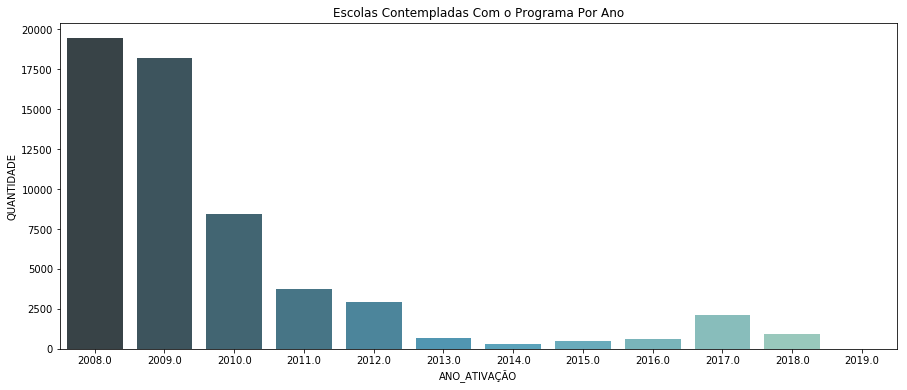

In [ ]:
#Gráfico escolas contempladas com o programa por ano
plt.figure(figsize=(15,6))
sns.barplot(data=df_ano_atv, x='ANO_ATIVAÇÃO', y='QUANTIDADE', palette='GnBu_d')
plt.title('Escolas Contempladas Com o Programa Por Ano')
plt.show()

## Distribuição das Velocidades do Programa

In [ ]:
#Distribuição das Velocidades
df_velocidades = pd.DataFrame(df_escolas['VELOCIDADE'][df_escolas['PBLE']==1].value_counts()).reset_index().sort_values('VELOCIDADE', ascending=False)
df_velocidades.columns = ['VELOCIDADE', 'QUANTIDADE']
df_velocidades

,VELOCIDADE,QUANTIDADE
0,2.0,31858
1,5.0,10150
2,10.0,8896
3,4.0,2918
4,15.0,2293
5,8.0,971
6,1.0,674
7,6.0,87
8,3.0,61
9,20.0,52


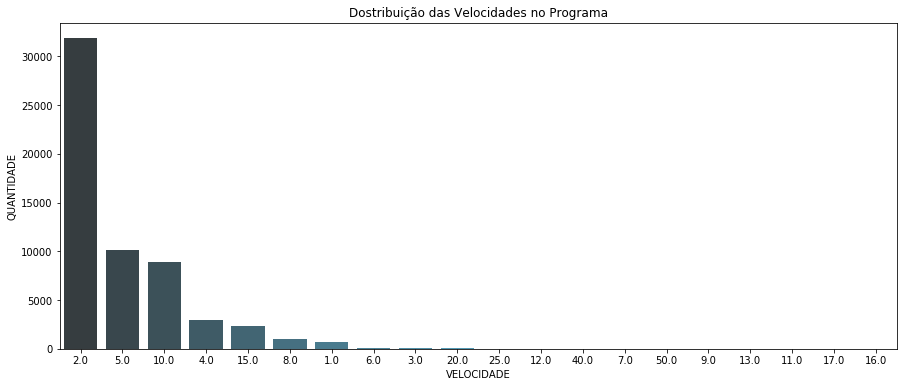

In [ ]:
#Gráfico distribuição das velocidades no programa
x = df_velocidades['VELOCIDADE'].tolist()
plt.figure(figsize=(15,6))
sns.barplot(data=df_velocidades, x='VELOCIDADE', y='QUANTIDADE', palette='GnBu_d', order=x)
plt.title('Dostribuição das Velocidades no Programa')
plt.show()

##  Tecnologias no Programa

In [ ]:
#Tipos de tecnologias
df_tecnologia = pd.DataFrame(df_escolas['TECNOLOGIA'][df_escolas['PBLE']==1].value_counts()).reset_index().sort_values('TECNOLOGIA', ascending=False)
df_tecnologia.columns = ['TECNOLOGIA', 'QUANTIDADE']
df_tecnologia

,TECNOLOGIA,QUANTIDADE
0,ADSL,53132
1,LP,2001
2,SATÉLITE,1923
3,REDE CELULAR,375
4,HDSL,360
5,FIBRA,122
6,RÁDIO,101
7,DEDICADO,9


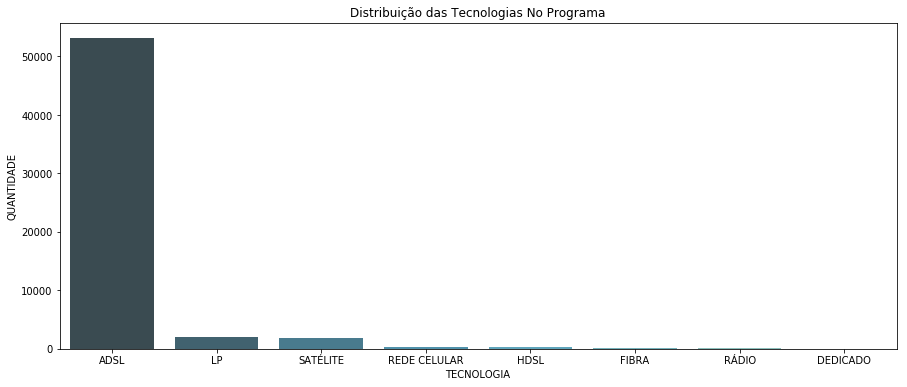

In [ ]:
#Gráfico distribuição das tecnologias do programa
plt.figure(figsize=(15,6))
sns.barplot(data=df_tecnologia, x='TECNOLOGIA', y='QUANTIDADE', palette='GnBu_d')
plt.title('Distribuição das Tecnologias No Programa')
plt.show()

## Plotando os Mapas

### Criando mapa de calor onde existe concentração de escolas

In [ ]:
base_map = generateBaseMap()
df_map = df_escolas[df_escolas['PBLE']==1][['LATITUDE', 'LONGITUDE']]
df_map['COUNT'] = 1
HeatMap(data=df_map.groupby(['LATITUDE', 'LONGITUDE']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

# Entendendo a Distruição de Notas

## Evolução das Notas das Escolas Públicas do Brasil

In [ ]:
table0 = df_escolas[['NOTA_2009',
                    'NOTA_2010',
                    'NOTA_2011',
                    'NOTA_2012',
                    'NOTA_2013',
                    'NOTA_2014',
                    'NOTA_2015',
                    'NOTA_2016',
                    'NOTA_2017',
                    'NOTA_2018']]

table0.dropna(inplace=True)

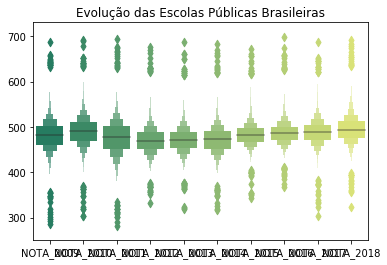

In [ ]:
plt.title('Evolução das Escolas Públicas Brasileiras')
sns.boxenplot(data=table0, palette='summer')
plt.show()

## Criando Grupo de Análise Para Identificar Evolução das Notas

### Grupo de Análise

Primeiro será necessário verificar qual o melhor grupo para análise. 

In [ ]:
df_escolas['ANO_ATIVACAO'].value_counts()

2008.0    19442
2009.0    18195
2010.0     8469
2011.0     3732
2012.0     2943
2017.0     2126
2018.0      946
2013.0      717
2016.0      654
2015.0      477
2014.0      292
2019.0       30
Name: ANO_ATIVACAO, dtype: int64

Pela Quantidade de observações e ser um ano um pouco mais recentes o grupo de análise será formado pelas escolas que entraram no programa em 2012. Vamos descer a análise, para verificar qual UF tem mais observações

In [ ]:
df_escolas[df_escolas['ANO_ATIVACAO']==2012]['UF'].value_counts().head()

SP    1871
PA     289
AM     150
PR      93
MG      56
Name: UF, dtype: int64

Por conter mais observações escolheremos as escolas de São Pulo que entraram no programa em 2012

In [ ]:
df_grupo_analise = df_escolas[(df_escolas['ANO_ATIVACAO']==2012) & (df_escolas['UF']=='SP')]

In [ ]:
df_grupo_analise.head()

,CO_ENTIDADE,NO_ENTIDADE,CD_GEOCUF,UF,CD_GEOCMU,MUNICIPIO,LATITUDE,LONGITUDE,CAPITAL,ESCOLA_MUNICIPAL,ESCOLA_ESTADUAL,ESCOLA_RURAL,ESCOLA_URBANA,IN_LOCAL_FUNC_PREDIO_ESCOLAR,IN_ALIMENTACAO,IN_AGUA_FILTRADA,IN_AGUA_REDE_PUBLICA,IN_ENERGIA_REDE_PUBLICA,IN_ESGOTO_REDE_PUBLICA,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_QUADRA_ESPORTES,IN_BIBLIOTECA,IN_SALA_LEITURA,IN_EQUIP_RETROPROJETOR,QT_COMP_ALUNO,TP_ATIVIDADE_COMPLEMENTAR,IN_BANDA_LARGA,PBLE,PRESTADORA,VELOCIDADE,TIPO_VELOCIDADE,TECNOLOGIA,DIA_ATIVACAO,MES_ATIVACAO,ANO_ATIVACAO,NOTA_2009,NOTA_2010,NOTA_2011,NOTA_2012,NOTA_2013,NOTA_2014,NOTA_2015,NOTA_2016,NOTA_2017,NOTA_2018,NOTA_FINAL
95247,35916924,EURYCLIDES DE JESUS ZERBINI,35,SP,3530607,Mogi das Cruzes,-23.5208,-46.1854,0,0,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,TELEFÔNICA,2.0,Mbps,LP,16.0,8.0,2012.0,462.180000,564.100000,NaN,470.162222,465.630,542.550000,467.532000,463.280000,473.445000,508.630000,490.834358
95250,35916961,JOSE RIBEIRO GUIMARAES,35,SP,3530607,Mogi das Cruzes,-23.5208,-46.1854,0,0,1,0,1,1,1,1,1,1,0,1,0,1,0,1,1,18,0,1,1,TELEFÔNICA,2.0,Mbps,ADSL,11.0,5.0,2012.0,NaN,NaN,NaN,484.496000,490.920,489.495000,502.923846,484.997391,484.948000,503.751667,491.647415
95252,35917011,FERNAO DIAS PAES LEME,35,SP,3513009,Cotia,-23.6022,-46.9190,0,0,1,0,1,1,1,1,1,1,0,1,0,1,0,0,1,9,1,1,1,TELEFÔNICA,8.0,Mbps,ADSL,7.0,5.0,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,474.290667,488.624000,NaN,NaN,481.457333
95254,35917084,LUIZ SCHUNCK,35,SP,3515103,Embu-Guaçu,-23.8297,-46.8136,0,0,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,13,1,1,1,TELEFÔNICA,8.0,Mbps,ADSL,20.0,4.0,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,499.060000,NaN,499.060000
95255,35917102,DOMINGOS MILANO,35,SP,3523107,Itaquaquecetuba,-23.4835,-46.3457,0,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,18,0,1,1,TELEFÔNICA,8.0,Mbps,ADSL,29.0,5.0,2012.0,457.124667,486.352258,470.165882,452.558182,473.023,454.443396,483.936000,480.657143,479.832195,494.730625,473.282335


### Análisando a evolução das notas do grupo de análise

In [ ]:
table = df_grupo_analise[['NOTA_2009',
                          'NOTA_2010',
                          'NOTA_2011',
                          'NOTA_2012',
                          'NOTA_2013',
                          'NOTA_2014',
                          'NOTA_2015',
                          'NOTA_2016',
                          'NOTA_2017',
                          'NOTA_2018']]

table.dropna(inplace=True)

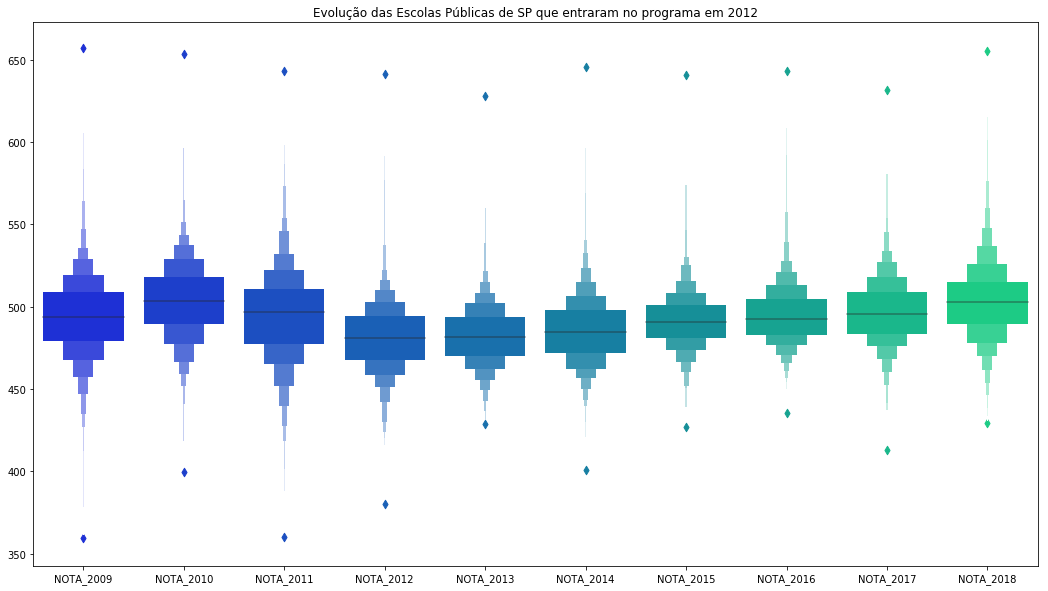

In [ ]:
plt.title('Evolução das Escolas Públicas de SP que entraram no programa em 2012')
sns.boxenplot(data=table, palette='winter')
plt.show()

## Criando Grupo de Análise Para Identificar Evolução das Notas

### Grupo de Controle

Como estamos utilizando escolas de São Paulo, vamos fazer um grupo parecido, porém com escolas que não possuem internet

In [ ]:
df_grupo_controle = df_escolas[(df_escolas['PBLE']==0) & (df_escolas['IN_BANDA_LARGA']==0) & (df_escolas['UF']=='SP')]

### Análisando a evolução das notas do grupo de controle

In [ ]:
table2 = df_grupo_controle[['NOTA_2009',
                          'NOTA_2010',
                          'NOTA_2011',
                          'NOTA_2012',
                          'NOTA_2013',
                          'NOTA_2014',
                          'NOTA_2015',
                          'NOTA_2016',
                          'NOTA_2017',
                          'NOTA_2018']]

table2.dropna(inplace=True)

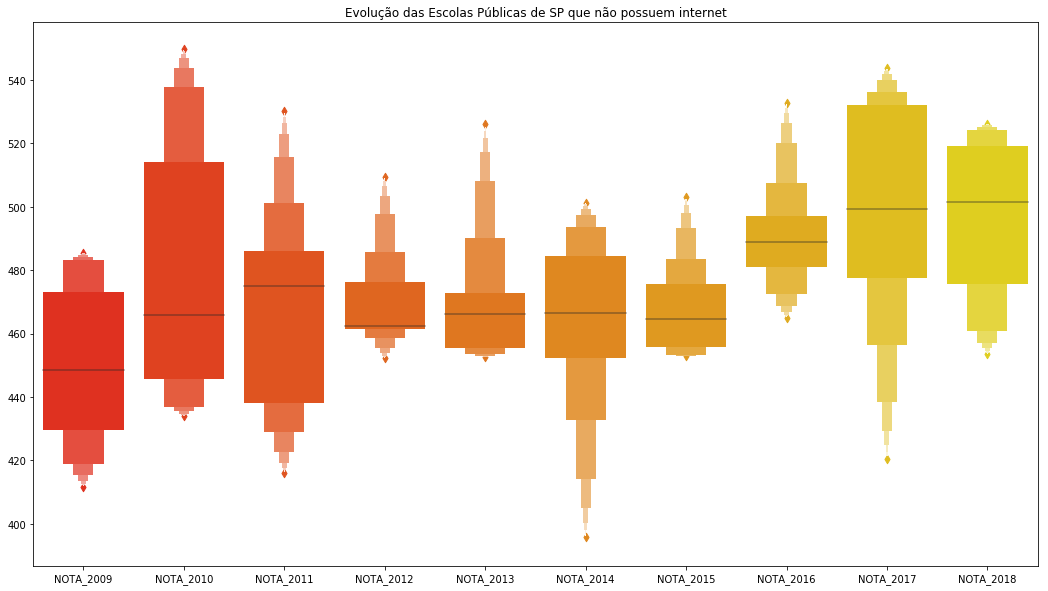

In [ ]:
rcParams['figure.figsize'] = 18,10
plt.title('Evolução das Escolas Públicas de SP que não possuem internet')
sns.boxenplot(data=table2, palette='autumn')
plt.show()

## Comparando Notas do Grupo Análise e Grupo Controle

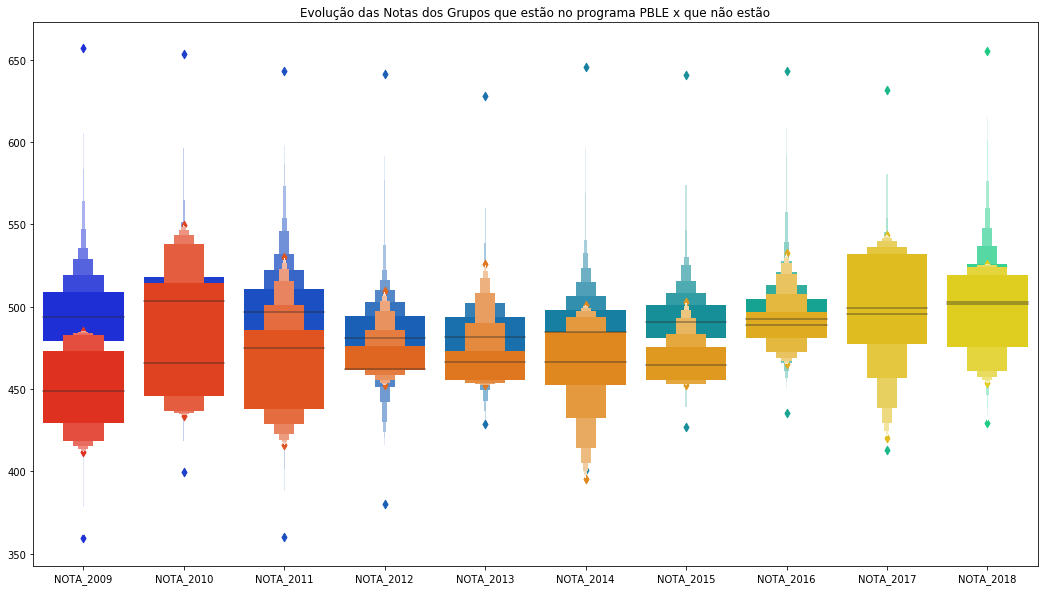

In [ ]:
plt.title('Evolução das Notas dos Grupos que estão no programa PBLE x que não estão')
sns.boxenplot(data=table, palette='winter')
sns.boxenplot(data=table2, palette='autumn')
plt.show()

# O que de fato influencía na Nota de um aluno afinal?

## Criando Modelo de Machine Learning

### Verificando as colunas do DF

In [ ]:
df_escolas.columns.tolist()

['CO_ENTIDADE',
 'NO_ENTIDADE',
 'CD_GEOCUF',
 'UF',
 'CD_GEOCMU',
 'MUNICIPIO',
 'LATITUDE',
 'LONGITUDE',
 'CAPITAL',
 'ESCOLA_MUNICIPAL',
 'ESCOLA_ESTADUAL',
 'ESCOLA_RURAL',
 'ESCOLA_URBANA',
 'IN_LOCAL_FUNC_PREDIO_ESCOLAR',
 'IN_ALIMENTACAO',
 'IN_AGUA_FILTRADA',
 'IN_AGUA_REDE_PUBLICA',
 'IN_ENERGIA_REDE_PUBLICA',
 'IN_ESGOTO_REDE_PUBLICA',
 'IN_LABORATORIO_INFORMATICA',
 'IN_LABORATORIO_CIENCIAS',
 'IN_QUADRA_ESPORTES',
 'IN_BIBLIOTECA',
 'IN_SALA_LEITURA',
 'IN_EQUIP_RETROPROJETOR',
 'QT_COMP_ALUNO',
 'TP_ATIVIDADE_COMPLEMENTAR',
 'IN_BANDA_LARGA',
 'PBLE',
 'PRESTADORA',
 'VELOCIDADE',
 'TIPO_VELOCIDADE',
 'TECNOLOGIA',
 'DIA_ATIVACAO',
 'MES_ATIVACAO',
 'ANO_ATIVACAO',
 'NOTA_2009',
 'NOTA_2010',
 'NOTA_2011',
 'NOTA_2012',
 'NOTA_2013',
 'NOTA_2014',
 'NOTA_2015',
 'NOTA_2016',
 'NOTA_2017',
 'NOTA_2018',
 'NOTA_FINAL']

### Definindo as colunas a serem utilizadas no modelo

In [ ]:
df_modelo = df_escolas[['UF',
                        'CAPITAL', 
                        'ESCOLA_MUNICIPAL', 
                        'ESCOLA_ESTADUAL', 
                        'ESCOLA_URBANA', 
                        'IN_LOCAL_FUNC_PREDIO_ESCOLAR',
                        'IN_ALIMENTACAO',
                        'IN_AGUA_FILTRADA',
                        'IN_AGUA_REDE_PUBLICA',
                        'IN_ENERGIA_REDE_PUBLICA',
                        'IN_ESGOTO_REDE_PUBLICA',
                        'IN_LABORATORIO_INFORMATICA',
                        'IN_LABORATORIO_CIENCIAS',
                        'IN_QUADRA_ESPORTES',
                        'IN_BIBLIOTECA',
                        'IN_SALA_LEITURA',
                        'IN_EQUIP_RETROPROJETOR',
                        'QT_COMP_ALUNO',
                        'TP_ATIVIDADE_COMPLEMENTAR',
                        'IN_BANDA_LARGA',
                        'PBLE',
                        'VELOCIDADE',
                        'NOTA_FINAL']]

### Verificando Nulos

In [ ]:
df_modelo.isnull().sum()

UF                                   0
CAPITAL                              0
ESCOLA_MUNICIPAL                     0
ESCOLA_ESTADUAL                      0
ESCOLA_URBANA                        0
IN_LOCAL_FUNC_PREDIO_ESCOLAR         0
IN_ALIMENTACAO                       0
IN_AGUA_FILTRADA                     0
IN_AGUA_REDE_PUBLICA                 0
IN_ENERGIA_REDE_PUBLICA              0
IN_ESGOTO_REDE_PUBLICA               0
IN_LABORATORIO_INFORMATICA           0
IN_LABORATORIO_CIENCIAS              0
IN_QUADRA_ESPORTES                   0
IN_BIBLIOTECA                        0
IN_SALA_LEITURA                      0
IN_EQUIP_RETROPROJETOR               0
QT_COMP_ALUNO                        0
TP_ATIVIDADE_COMPLEMENTAR            0
IN_BANDA_LARGA                       0
PBLE                                 0
VELOCIDADE                       83649
NOTA_FINAL                      111577
dtype: int64

### Tratando Nulos

In [ ]:
df_modelo['VELOCIDADE'].fillna(0, inplace=True)
df_modelo.dropna(axis=0, inplace=True)

### Verificando Nulos

In [ ]:
df_modelo.isnull().sum()

UF                              0
CAPITAL                         0
ESCOLA_MUNICIPAL                0
ESCOLA_ESTADUAL                 0
ESCOLA_URBANA                   0
IN_LOCAL_FUNC_PREDIO_ESCOLAR    0
IN_ALIMENTACAO                  0
IN_AGUA_FILTRADA                0
IN_AGUA_REDE_PUBLICA            0
IN_ENERGIA_REDE_PUBLICA         0
IN_ESGOTO_REDE_PUBLICA          0
IN_LABORATORIO_INFORMATICA      0
IN_LABORATORIO_CIENCIAS         0
IN_QUADRA_ESPORTES              0
IN_BIBLIOTECA                   0
IN_SALA_LEITURA                 0
IN_EQUIP_RETROPROJETOR          0
QT_COMP_ALUNO                   0
TP_ATIVIDADE_COMPLEMENTAR       0
IN_BANDA_LARGA                  0
PBLE                            0
VELOCIDADE                      0
NOTA_FINAL                      0
dtype: int64

### Shape do DF a ser utilizado no modelo

In [ ]:
df_modelo.shape

(30095, 23)

### Definindo X e y

In [ ]:
X = df_modelo.drop(['NOTA_FINAL'], axis=1)
y = np.log1p(df_modelo['NOTA_FINAL'])

In [ ]:
X = pd.get_dummies(X, drop_first=True)

### Metrificando o Modelo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Escolhendo o melhor modelo

In [ ]:
xgb_model = xgb.XGBRegressor()
linear_model = LinearRegression()
rforest_model = RandomForestRegressor()
grad_model = GradientBoostingRegressor()

models = [xgb_model, linear_model, rforest_model, grad_model]


for model in models:
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)

    #Metrics
    r2 = r2_score(y_test, yhat)
    mse = mean_squared_error(y_test, yhat)

    
    print("="*30)
    print(f'Model {str(model)}')
    print('****Results****')
    print(f'R2: {round(r2, 4)}\n')
    print(f'MSE: {round(mse, 4)}\n')

[20:19:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
****Results****
R2: 0.2691

MSE: 0.0058

Model LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
****Results****
R2: 0.2519

MSE: 0.0059

Model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
  

## Rodando Modelo escolhido em toda Base

In [ ]:
model = GradientBoostingRegressor()
model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Features Mais Importantes

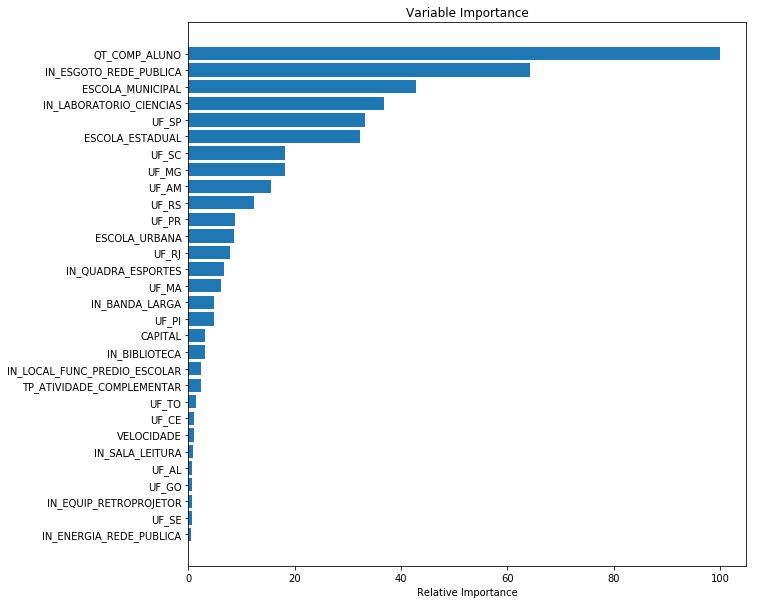

In [ ]:
feature_importance = model.feature_importances_
limite = 30

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-limite:]

pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Abrindo o Modelo com o Pacote SHAP

### Explicando Predições

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

### Importancia das Variáveis

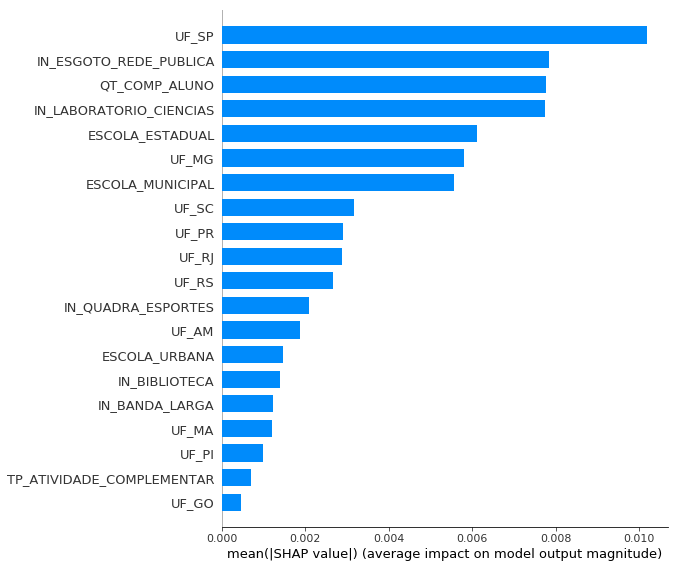

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

### Summary Plot

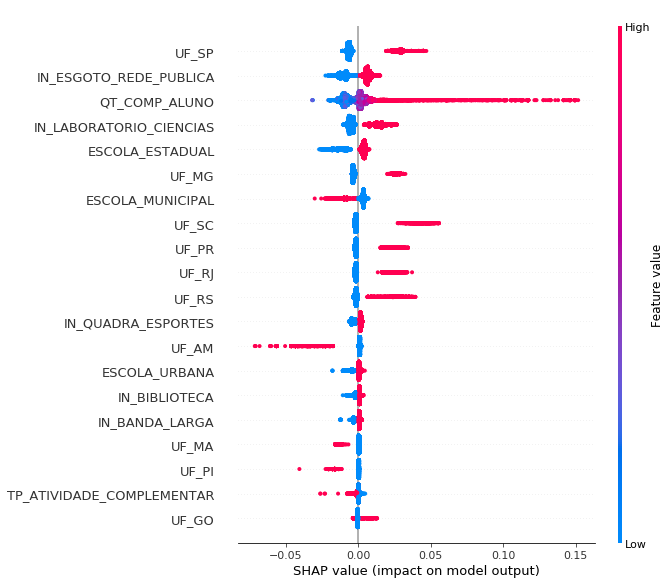

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:47,:], X.iloc[:47,:])

# Fazendo Previsões

## Criando DF

In [ ]:
df_prev = df_escolas[['UF',
                        'CAPITAL', 
                        'ESCOLA_MUNICIPAL', 
                        'ESCOLA_ESTADUAL', 
                        'ESCOLA_URBANA', 
                        'IN_LOCAL_FUNC_PREDIO_ESCOLAR',
                        'IN_ALIMENTACAO',
                        'IN_AGUA_FILTRADA',
                        'IN_AGUA_REDE_PUBLICA',
                        'IN_ENERGIA_REDE_PUBLICA',
                        'IN_ESGOTO_REDE_PUBLICA',
                        'IN_LABORATORIO_INFORMATICA',
                        'IN_LABORATORIO_CIENCIAS',
                        'IN_QUADRA_ESPORTES',
                        'IN_BIBLIOTECA',
                        'IN_SALA_LEITURA',
                        'IN_EQUIP_RETROPROJETOR',
                        'QT_COMP_ALUNO',
                        'TP_ATIVIDADE_COMPLEMENTAR',
                        'IN_BANDA_LARGA',
                        'PBLE',
                        'VELOCIDADE',
                        'NOTA_2018']]

### Tratando Nulos

In [ ]:
df_prev['VELOCIDADE'].fillna(0, inplace=True)
df_prev.dropna(axis=0, inplace=True)

### Definindo X e y

In [ ]:
X = df_prev.drop(['NOTA_2018'], axis=1)
y = np.log1p(df_prev['NOTA_2018'])

In [ ]:
X = pd.get_dummies(X, drop_first=True)

## Treinando Modelo

In [ ]:
model = GradientBoostingRegressor()
model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Prevendo a nota se todas as escolas tivessem o básico

In [ ]:
X_prev = X

In [ ]:
X_prev['IN_ESGOTO_REDE_PUBLICA'] = 1

### Prevendo Valores

In [ ]:
y_pred = model.predict(X_prev)

### Atribuindo valores preditos como novas notas

In [ ]:
df_predicao_notas = pd.DataFrame(np.exp(y_pred), columns=['PREDICAO'])

In [ ]:
df_escolas_concat = pd.concat([df_escolas, df_predicao_notas], axis=1)

### Verificando novo Boxplot

In [ ]:
table_notas = df_escolas_concat[['NOTA_2009',
                                 'NOTA_2010',
                                 'NOTA_2011',
                                 'NOTA_2012',
                                 'NOTA_2013',
                                 'NOTA_2014',
                                 'NOTA_2015',
                                 'NOTA_2016',
                                 'NOTA_2017',
                                 'NOTA_2018',
                                 'PREDICAO']]

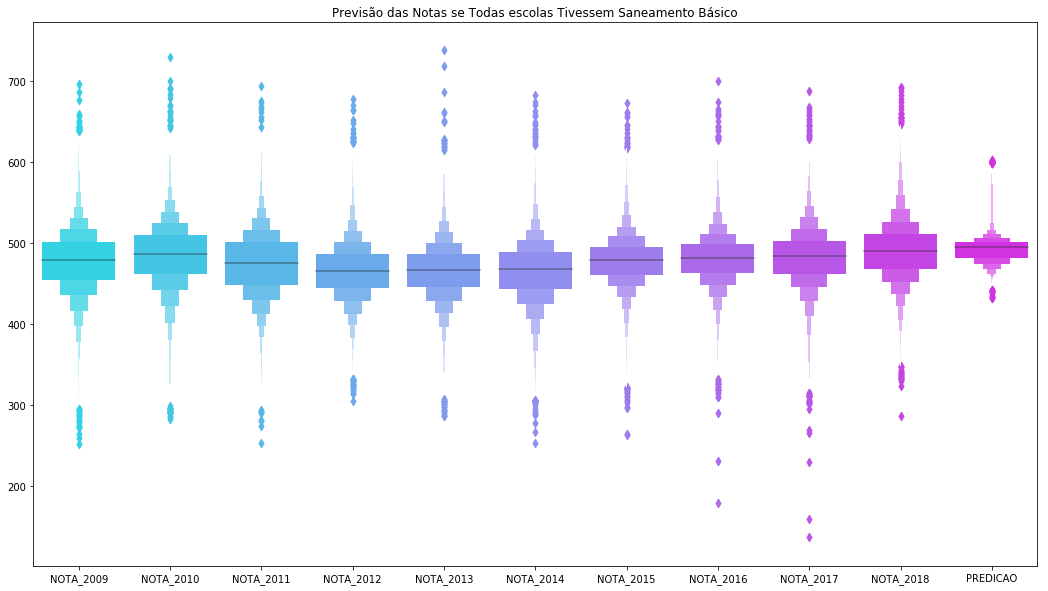

In [ ]:
plt.title('Previsão das Notas se Todas escolas Tivessem Saneamento Básico')
sns.boxenplot(data=table_notas, palette='cool')
plt.show()